In [3]:
import pandas as pd

inputFile = 'preprocessed_data_train.csv'
metaFile = 'meta_train.csv'
df = pd.read_csv(inputFile)

# Drop the indexes column
del df['FileName']
del df['timestamp']

# Extract the column INDOOR that represent the target of the neural network
target = df.loc[:,'INDOOR'].to_numpy()
del df['INDOOR']

df_meta = pd.read_csv(metaFile)

In [4]:
import tensorflow as tf
from sklearn.model_selection import train_test_split

# Split the whole train dataset into a test and train set 
X_train, X_test, y_train, y_test = train_test_split(df.to_numpy(), target, test_size=0.33) 
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

(96217, 21) (47391, 21) (96217,) (47391,)


In [5]:
# Number of features present into the vector
D = X_train.shape[1]
D

21

In [6]:
# Create the model of the Neural Network with the following layers:
i = tf.keras.layers.Input(shape=(D,),name='Input')
x = tf.keras.layers.Dense(32,activation='sigmoid', name='Hidden')(i)
x = tf.keras.layers.Dropout(0.8)(x)
x = tf.keras.layers.Dense(1, activation='sigmoid', name='Classifier')(x)
model = tf.keras.models.Model(i, x)

model.summary()
tf.keras.utils.plot_model(model,show_shapes=True,show_dtype=True, show_layer_names=True, expand_nested=True)

learning_rate = 0.01
batch_size = 16

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

model.compile(
    optimizer=optimizer,
    loss="binary_crossentropy",
    metrics=['accuracy'],
  )

# Train the model
r = model.fit(X_train, y_train, validation_data = (X_test, y_test) ,batch_size=batch_size, epochs=25)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 21)]              0         
_________________________________________________________________
Hidden (Dense)               (None, 32)                704       
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
Classifier (Dense)           (None, 1)                 33        
Total params: 737
Trainable params: 737
Non-trainable params: 0
_________________________________________________________________
Epoch 1/25
6014/6014 [==============================] - 7s 1ms/step - loss: 0.4147 - accuracy: 0.8115 - val_loss: 0.1954 - val_accuracy: 0.9262
Epoch 2/25
6014/6014 [==============================] - 6s 1ms/step - loss: 0.2887 - accuracy: 0.8835 - val_loss: 0.1

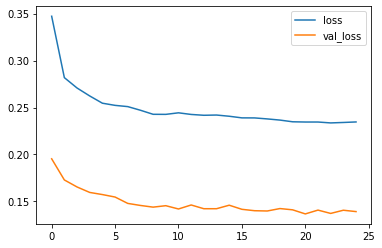

In [7]:
import matplotlib.pyplot as plt

plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()

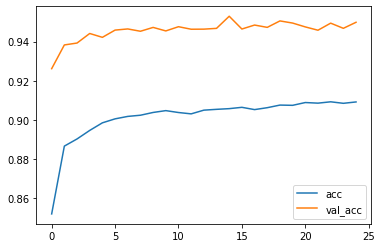

In [8]:
# Plot the accuracy too
plt.plot(r.history['accuracy'], label='acc')
plt.plot(r.history['val_accuracy'], label='val_acc')
plt.legend()

In [9]:
model.save('IODetector_32_5_tfmodel')

INFO:tensorflow:Assets written to: IODetector_32_5_tfmodel/assets


In [10]:
!zip -r IODetector_32_5_tfmodel.zip IODetector_32_5_tfmodel

  adding: IODetector_32_5_tfmodel/ (stored 0%)
  adding: IODetector_32_5_tfmodel/variables/ (stored 0%)
  adding: IODetector_32_5_tfmodel/variables/variables.index (deflated 60%)
  adding: IODetector_32_5_tfmodel/variables/variables.data-00000-of-00001 (deflated 27%)
  adding: IODetector_32_5_tfmodel/saved_model.pb (deflated 87%)
  adding: IODetector_32_5_tfmodel/assets/ (stored 0%)


# Adding to the model the metadata and exporting them into tflite format

In [11]:
!pip install tflite_support

     |████████████████████████████████| 1.1MB 12.7MB/s 
     |████████████████████████████████| 194kB 49.1MB/s 


In [12]:
from tflite_support import flatbuffers
from tflite_support import metadata as _metadata
from tflite_support import metadata_schema_py_generated as _metadata_fb

In [13]:
# Creates model info.
model_meta = _metadata_fb.ModelMetadataT()
model_meta.name = "IODetector model"
model_meta.description = "Detect if the user is indoor or outdoor."
model_meta.version = "v1"
model_meta.author = "Dario Lorenzoni, Niccolò Scatena"
model_meta.license = "MIT LICENSE"

In [14]:
input_meta = _metadata_fb.TensorMetadataT()
input_meta.name = "feature_vector"
input_meta.description = "IODetection input vector"
input_meta.content = _metadata_fb.ContentT()
input_meta.content.content_properties = _metadata_fb.FeaturePropertiesT()
input_meta.content.contentPropertiesType = (_metadata_fb.ContentProperties.FeatureProperties)
input_normalization = _metadata_fb.ProcessUnitT()
input_normalization.optionsType = (_metadata_fb.ProcessUnitOptions.NormalizationOptions)
input_normalization.options = _metadata_fb.NormalizationOptionsT()
input_normalization.options.mean = df_meta.iloc[1, 1:].values.tolist()
input_normalization.options.std = df_meta.iloc[2, 1:].values.tolist()
input_meta.processUnits = [input_normalization]
input_stats = _metadata_fb.StatsT()
input_stats.min = df_meta.iloc[3, 1:].values.tolist()
input_stats.max = df_meta.iloc[7, 1:].values.tolist()
input_meta.stats = input_stats

In [15]:
output_meta = _metadata_fb.TensorMetadataT()
output_meta.name = "IODetection"
output_meta.description = "Indoor/Outdoor label."
output_meta.content = _metadata_fb.ContentT()
output_meta.content.content_properties = _metadata_fb.FeaturePropertiesT()
output_meta.content.contentPropertiesType = (_metadata_fb.ContentProperties.FeatureProperties)
output_stats = _metadata_fb.StatsT()
output_stats.min = [0.0]
output_stats.max = [1.0]
output_meta.stats = output_stats

In [16]:
# Creates subgraph info.
subgraph = _metadata_fb.SubGraphMetadataT()
subgraph.inputTensorMetadata = [input_meta]
subgraph.outputTensorMetadata = [output_meta]
model_meta.subgraphMetadata = [subgraph]

b = flatbuffers.Builder(0)
b.Finish(
    model_meta.Pack(b),
    _metadata.MetadataPopulator.METADATA_FILE_IDENTIFIER)
metadata_buf = b.Output()

In [17]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model.
with open('IODetectorModel.tflite', 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmp4jby9wjt/assets


In [18]:
populator = _metadata.MetadataPopulator.with_model_file('IODetectorModel.tflite')
populator.load_metadata_buffer(metadata_buf)
populator.populate()

In [19]:
displayer = _metadata.MetadataDisplayer.with_model_file('IODetectorModel.tflite')
export_json_file = "meta.json"
json_file = displayer.get_metadata_json()
with open(export_json_file, "w") as f:
  f.write(json_file)

In [20]:
!tflite_codegen --model=./IODetectorModel.tflite \
    --package_name=it.unipi.dii.iodetectionlib.ml.generated \
    --model_class_name=IODetectorModel \
    --destination=./classify_wrapper

!zip -r classify_wrapper.zip classify_wrapper/

I0522 08:42:37.917580 140281917171584 codegen.py:88] Generation succeeded!
I0522 08:42:37.917866 140281917171584 codegen.py:93] Model copied into assets!
  adding: classify_wrapper/ (stored 0%)
  adding: classify_wrapper/iodetectormodel.md (deflated 49%)
  adding: classify_wrapper/build.gradle (deflated 60%)
  adding: classify_wrapper/src/ (stored 0%)
  adding: classify_wrapper/src/main/ (stored 0%)
  adding: classify_wrapper/src/main/AndroidManifest.xml (deflated 24%)
  adding: classify_wrapper/src/main/java/ (stored 0%)
  adding: classify_wrapper/src/main/java/it/ (stored 0%)
  adding: classify_wrapper/src/main/java/it/unipi/ (stored 0%)
  adding: classify_wrapper/src/main/java/it/unipi/dii/ (stored 0%)
  adding: classify_wrapper/src/main/java/it/unipi/dii/iodetectionlib/ (stored 0%)
  adding: classify_wrapper/src/main/java/it/unipi/dii/iodetectionlib/ml/ (stored 0%)
  adding: classify_wrapper/src/main/java/it/unipi/dii/iodetectionlib/ml/generated/ (stored 0%)
  adding: classify_wrap